**Background:**
Due to language barriers, a US-based life insurance company is facing a challenge in communicating with the Spanish-speaking community in Mexico. The locals there need help in understanding English, and the company cannot provide translators for all of them. To overcome this challenge and provide coverage to the locals, the company needs a machine translation model that can accurately translate the application request letter from Spanish to English.

**Problem Statement:** Your task is to build an **attention-based sequence-to-sequence model** that can effectively understand the context of Spanish sentences and translate them into clear and coherent English sentences. The company aims to use this model to ensure seamless communication and provide coverage to the Spanish-speaking community in Mexico.


**Objectives:**
To explore the challenges of working with low-resource languages.
Implement an encoder-decoder NMT model with attention.

**Terminal Objective:**
To build and train an NMT model that can accurately translate Spanish sentences to English and vice versa.


### **Overall objectives:**
The objective of this assignment is to build a Sequence to Sequence model for Spanish to English translation.

The code is broken down into several pipelines:
* Task 1: Load the data
* Task 2: Process the data
* Task 3: Build the NMT model
* Task 4: Train the NMT model
* Task 5: Evaluate the NMT model

*Note: the details of each of the above task are elaborated in various parts of this stub code.



### **How to read this stub code file and solve this assignment**

*   All the tasks and details around how to perform them are mentioned in detail in this stub code file.

*   You need to go through the instructions mentioned as 'comments' in the stub code file and add a code where there is a **---** given or where it would be mentioned as **'fill this'**.

*   To understand the complete flow of that particular section and it's sub-tasks, scroll through the table of contents section in the left tab of this stub code file.

*   In case, for any existing part of code, or for something already written, you may or may not modify it, as long as you are serving the purpose of the task required in that section.

### **Task 1. Load the data**

#### 1.0 Importing Libraries

In [1]:
import os,io
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import tensorflow as tf

#### 1.1 Downloading the dataset

The dataset used is a paired corpus of **English-Spanish**, provided by [Anki](https://www.manythings.org/anki/).

The code starts by downloading a zip file containing the dataset for English to Spanish translation. The dataset is stored in the `spa-eng` folder and can be found in the file named `spa.txt`.

Let's take a look at how the data looks like

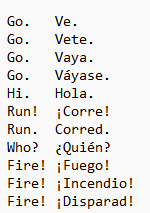

- Each line in the `spa.txt` file contains an English word/sentence and their corresponding Spanish translation.

- Some words might have multiple translation because of context.

- Our first objective is to extract each line, and then separate the  English and Spanish words/sentences into two separate arrays. These will act as our input and target sentences for training the model

In [2]:
# Downloading the file
zip_file = tf.keras.utils.get_file(
    'spa-eng.zip', origin='http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip',
    extract=True)

file_path = os.path.dirname(zip_file)+"/spa-eng/spa.txt"

2638744/2638744 [==============================] - 0s 0us/step


#### 1.2. Load the data

Next step is to load the data and split it into two arrays `src_sentences` and `tgt_sentences`. For performing this task, we create a function `load_data`

The function **load_data()** should read a file located at `file_path` and returns the text content split into source and target arrays.



In [3]:
def load_data(path, size=None):
    """
    This function reads a file located at `path` and returns the text content split into source and target arrays.
    The data in the file should be separated by tabs and have source and target text separated by a newline.

    Args:
    - path: str, the path to the file
    - size: int, the number of lines to read from the file. If not provided or None, the function will read all lines.

    Returns:
    - source: numpy array, the array containing source text.
    - target: numpy array, the array containing target text.

    """
    text = io.open(path, encoding='UTF-8').read()

    # lines =  # split the text into lines separated by newline # Insert Code Here ----
    # pairs =  # split each line into source and target using tabs # Insert Code Here ----

    lines =  text.split("\n") # split the text into lines separated by newline
    pairs =  [line.split("\t") for line in lines if "\t" in line] # split each line into source and target using tabs

    source = np.array([source for target, source in pairs])  # extract source text into a numpy array
    target = np.array([target for target, source in pairs])  # extract target text into a numpy array

    return source, target


In [4]:
src_sentences, tgt_sentences = load_data(file_path)
print("Original Sentence:",src_sentences[42])
print("Translated Sentence:",tgt_sentences[42])

Original Sentence: Yo lo sé.
Translated Sentence: I know.


#### 1.3 Visualize the data

In the next subtask, we'll take a slight detour, and covert the given source and target sentences into a DataFrame and visualize the word/sentence-length distribution. It is important to analyze and visualize the corpus of data so that their sentence length distribution can be understood.

Visualizing sentence length distribution helps in understanding data, making decisions about preprocessing, determining appropriate padding/truncation, and batch size for NMT model training.

In [5]:
#Create a dataframe
df = pd.DataFrame(zip(src_sentences, tgt_sentences), columns=['source_sentence', 'target_sentence'])
df

,source_sentence,target_sentence
0,Ve.,Go.
1,Vete.,Go.
2,Vaya.,Go.
3,Váyase.,Go.
4,Hola.,Hi.
...,...,...
118959,Hay cuatro causas principales de muertes relac...,There are four main causes of alcohol-related ...
118960,Hay madres y padres que se quedan despiertos d...,There are mothers and fathers who will lie awa...
118961,Una huella de carbono es la cantidad de contam...,A carbon footprint is the amount of carbon dio...
118962,Como suele haber varias páginas web sobre cual...,Since there are usually multiple websites on a...


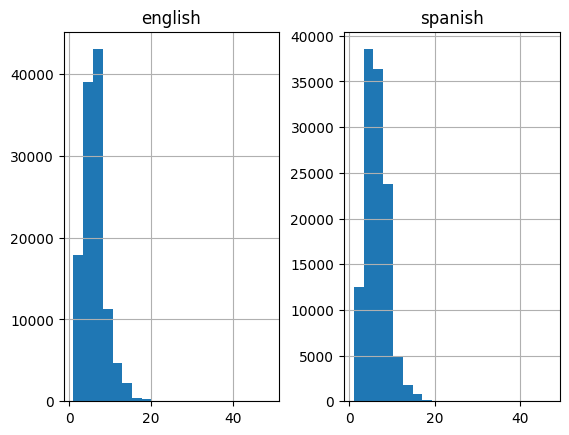

In [6]:
eng_len = []
span_len = []

# populate the lists with sentence lengths
for i in src_sentences:
      eng_len.append(len(i.split()))

for i in tgt_sentences:
      span_len.append(len(i.split()))

length_df = pd.DataFrame({'english':eng_len, 'spanish':span_len})

length_df.hist(bins = 20)
plt.show()

### **Task 2: Process the data**

Once we have loaded the dataset, and obtained the source and target sentences, we process the data with the following steps:

* Apply basic text preprocessing techniques to clean the data.
* Tokenize each sentence to their vector representation, add <*start*> & <*end*> tokens & *pad* each sentence to a maximum length.
* Split the source & target sentences to train & validation data
* Create a `tf.dataset` from the `tf.data` [API](https://www.tensorflow.org/guide/data). This API helps you build & work with complex input pipelines which allows you to handle large amounts of data and perform complex transformations on them.

##### 2.1 Clean the data


In [7]:
import re, itertools
from collections import Counter
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

###### 2.1.1 Text Standardization

The model is dealing with multilingual text with a limited vocabulary. So it will be important to standardize the input text. The first step is Unicode normalization to split accented characters and replace compatibility characters with their ASCII equivalents.

For example

- Input: Yo lo sé.
- Output: <*sos*> yo lo se . <*eos*>

In [8]:
import unicodedata

def unicode_to_ascii(s):
    # Normalize the input string `s` to its decomposed form
    normalized = unicodedata.normalize('NFD', s)
    # Return a new string that only contains ASCII characters
    # Exclude characters with the category "Mark, Nonspacing"
    return ''.join(c for c in normalized if unicodedata.category(c) != 'Mn')

def preprocess_text(text):
  """
  Preprocess the input text data by removing special characters, lowercasing it and adding start and end tokens

  Arguments:
    text (str): Input text string

  Returns:
    preprocessed_text (str): Preprocessed text string with added start and end tokens
  """
  # Lowercase all the text using unicode to ascii conversion. You can call the unicode_to_ascii function defined earlier
  text = unicode_to_ascii(text.lower())

  # Replacing special characters with space except (a-z, A-Z, ".", "?", "!", ",")
  text = re.sub(r"[^a-zA-Z.?!,' ]", " ", text)

  # Search for (?, ., !, ,, or ¿)and insert a space before and after each match.
  text = re.sub(r"([?.!,¿])", r" \1 ", text)

  # Search for one or more consecutive spaces and replace them with a single space.
  text = re.sub(r"\s+", " ", text)

  # Strip whitespace.
  text = text.strip()

  # Add the <start> & <end> tokens
  text = '<sos> ' + text + ' <eos>'

  return text


In [9]:
# Write a Code below for cleaning the source and target sentences. You can call the 'preprocess_text' function defined earlier

clean_src_sentences = []
for src_sentence in src_sentences:
  clean_src_sentences.append(preprocess_text(src_sentence))

clean_tgt_sentences = []
for tgt_sentence in tgt_sentences:
  clean_tgt_sentences.append(preprocess_text(tgt_sentence))


# Also now write a code for checking a sample of an orginal sentence and the processed sentence
# For example: the output could be as original text: Yo lo sé. Text after pre-processing: <sos> yo lo se . <eos>

src_sentences[42], clean_src_sentences[42]

('Yo lo sé.', '<sos> yo lo se . <eos>')

#### 2.2 Tokenize the data

Once, the sentences are splitted and special tokens are added, the process of tokenization is carried out using the **Tokenizer** class from the **tensorflow.keras.preprocessing.text** module.

Steps:

* The Tokenizer object is initialized and fit to the text data.
* The texts are then tokenized, meaning that each word is assigned a unique number.
* The resulting sequences are then padded and truncated to make all of them of equal length.

We'll create a function named `tokenize` to perform all the above steps together. Here's an example of how the function will transform an input sentence:

- Input: <*sos*> yo lo se . <*eos*>
- Output:  [ 1 26 18 17  3  2  0  0  0  0  0  0  0  0  0  0]

In [10]:
def tokenize(sentences):
    """
    Tokenizes the input sentences and returns the tokenized sequences, tokenizer object, and the max length of the sequences.

    Parameters:
    sentences (list): A list of sentences to be tokenized.

    Returns:
    sequences (numpy array): The tokenized sequences.
    lang_tokenizer (Tokenizer object): Tokenizer object fit on the input sentences.
    max_length (int): Maximum length of the sequences.

    """
    # Initialize the tokenizer object
    lang_tokenizer = Tokenizer( filters='')
    # Fit the tokenizer on the input sentences
    lang_tokenizer.fit_on_texts(sentences)
    # Tokenize the sentences
    sequences = lang_tokenizer.texts_to_sequences(sentences)
    # Find the max length of the sequences
    max_length = max(len(s) for s in sequences)
    # Pad and truncate the sequences
    sequences = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')

    return sequences, lang_tokenizer, max_length


###### 2.2.1 Create source and target sequences using tokenize()

Before we apply the **tokenize()** function, we need to make an important consideration. We won't be able to apply the processing and tokenization function to the entire dataset as it will exhaust all the available RAM. Hence, it is recommended to limit the data. Training on the complete dataset of >100,000 sentences will take a long time.

To train faster, we can limit the size of the dataset to `40,000` sentences

(***Note***: *Translation quality degrades with less data, however for demonstration purposes, we have gone for a faster training process*).

To filter the data, process & tokenize them, we can build a function `load_sequences` that perform all the three tasks inside it. This function will return the source, target sequences,  their maximum length & the tokenisers used for them.

In [14]:
def load_sequences(path, size=None):
    """
    Loads and preprocesses the dataset.

    Parameters:
    - path (str): The path to the dataset file.
    - size (int, optional): The number of data points to load. Default is None which loads all the data.

    Returns:
    - src_sequences (np.array): Array of preprocessed and tokenized source sentences.
    - tgt_sequences (np.array): Array of preprocessed and tokenized target sentences.
    - src_lang_tokenizer (Tokenizer): Tokenizer object fit on source sentences.
    - tgt_lang_tokenizer (Tokenizer): Tokenizer object fit on target sentences.
    - max_length_src (int): Maximum length of source sequences.
    - max_length_trg (int): Maximum length of target sequences.
    """
    # Load the data again using the load_data function with the size argument
    src_sentences, tgt_sentences = load_data(file_path)

    # Preprocess the source and target sentences
    processed_src_sentences = []
    for src_sentence in src_sentences:
      processed_src_sentences.append(preprocess_text(src_sentence))

    processed_tgt_sentences = []
    for tgt_sentence in tgt_sentences:
      processed_tgt_sentences.append(preprocess_text(tgt_sentence))

    # Tokenize the source and target sentences
    src_sequences, src_lang_tokenizer, max_length_src= tokenize(processed_src_sentences)
    tgt_sequences, tgt_lang_tokenizer, max_length_trg= tokenize(processed_tgt_sentences)

    return src_sequences, tgt_sequences, src_lang_tokenizer, tgt_lang_tokenizer, max_length_src, max_length_trg


In [15]:
#Write a code below to print the src sequences and tgt sequences shape

src_sequences, tgt_sequences, src_lang_tokenizer, tgt_lang_tokenizer, max_length_src, max_length_trg = load_sequences(file_path)
src_sequences.shape, tgt_sequences.shape

((118964, 53), (118964, 51))

In [16]:
print("Original sentence:", src_sentences[42])
print("Text after preprocessing:", clean_src_sentences[42])
print("Text after tokenization:", src_sequences[42])

Original sentence: Yo lo sé.
Text after preprocessing: <sos> yo lo se . <eos>
Text after tokenization: [ 1 37 20 15  3  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0]


###### 2.2.2 Understanding what's happening inside

We're taking another detour here, to understand how the tokenisation layer converts a batch of strings into a batch of token IDs.

Using the **.index_word()** method, we can convert the token IDs back to words for understanding the mapping and what's under the hood.

**Note**: This is not required for the final model building process, and is only shown for your understanding

In [18]:
#Testing if the word to index / index to word mappings have been obtained correctly.
def convert(lang, tensor):
  for t in tensor:
    if t!=0:
      print ("%d ----> %s" % (t, lang.index_word[t]))

print ("Input Language; index to word mapping")
convert(src_lang_tokenizer, src_sequences[42])
print ()
print ("Target Language; index to word mapping")
convert(tgt_lang_tokenizer, tgt_sequences[42])

Input Language; index to word mapping
1 ----> <sos>
37 ----> yo
20 ----> lo
15 ----> se
3 ----> .
2 ----> <eos>

Target Language; index to word mapping
1 ----> <sos>
5 ----> i
42 ----> know
3 ----> .
2 ----> <eos>


In [19]:
# getting the size of the input and output vocabularies.
src_vocab_size = len(src_lang_tokenizer.word_index)+1
tgt_vocab_size = len(tgt_lang_tokenizer.word_index)+1
print(src_vocab_size)
print(tgt_vocab_size)

24803
13296


#### 2.4 Train-Test Split
Now that we have processed the data, it's time to split it into train and test datasets. This way, we can use the train data to train our model and evaluate the model performance on the test data.

The ***train_test_split()*** function from the sklearn library is used to split the data. `src_sequences` and `tgt_sequences` are the input and target sequences respectively. The test_size parameter specifies the proportion of the data that should be used for testing, and random_state is used to set the random seed for reproducibility.

In [20]:
# Write a code below to extract & print the source and target sentences length for train and validation data

source_sequences_train, source_sequences_val, tgt_sequences_train, tgt_sequences_val = train_test_split(src_sequences, tgt_sequences, test_size=0.2, random_state=7)

#### 2.5 Create a ***tf.dataset***

The input pipeline starts from importing the data and creating a dataset from the data stored in the memory. For this, you can use `tf.data.Dataset.from_tensor_slices()`, which creates a **tf.data.Dataset** the object whose elements are slices of the passed tensors. Once you have created the object, you can transform it by applying different operations to the dataset object. (for example, Dataset.map() orDataset.batch()).

From the arrays of sequences created ater tokenisation, you can create a tf.data.Dataset of strings that shuffles and batches them efficiently

###### 2.5.1 Defining Hyperparameters
The following hyperparameters for the creating the **tf.dataset** (and later for model building purposes as well) are specified:
- `buffer_size`: This represents the buffer size for the training data. It is calculated by taking the length of the `source_sequences_train` array.
- `val_buffer_size`: This represents the buffer size for the validation data. It is calculated by taking the length of the `source_sequences_val` array.
- `BATCH_SIZE`: This represents the batch size for the training process. It is set to 64.
- `embedding_dim`: This represents the embedding dimension for the input data. It is set to 128.
- `units`: This represents the number of units in the recurrent neural network (RNN) used for the model. It is set to 1024.
- `steps_per_epoch`: This represents the number of steps to take during each epoch of training. It is calculated as the `buffer_size` divided by the `BATCH_SIZE`.
- `val_steps_per_epoch`: This represents the number of validation steps to take during each epoch of training. It is calculated as the `val_buffer_size` divided by the `BATCH_SIZE`.
It is important to note that these hyperparameters have been selected based on heuristics and may need to be fine-tuned for different problems or data sets.

In [21]:
#Defining hyperparameters
buffer_size=len(source_sequences_train)
val_buffer_size = len(source_sequences_val)
BATCH_SIZE = 64
embedding_dim = 128
units = 1024
steps_per_epoch = buffer_size//BATCH_SIZE
val_steps_per_epoch = val_buffer_size//BATCH_SIZE

In [22]:
# Create a dataset object for the training set
train_dataset = tf.data.Dataset.from_tensor_slices((source_sequences_train, tgt_sequences_train))

# Shuffle and batch the training set
train_dataset = train_dataset.shuffle(buffer_size=buffer_size).batch(BATCH_SIZE)

# Create a dataset object for the validation set
val_dataset = tf.data.Dataset.from_tensor_slices((source_sequences_val, tgt_sequences_val))

# Batch the validation set
val_dataset = val_dataset.batch(BATCH_SIZE)

In [23]:
# Printing the shape of an input batch
example_input_batch, example_target_batch = next(iter(train_dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 53]), TensorShape([64, 51]))

### **Task 3: Build the NMT model**

Let's take a recap of what we have done so far and what we have to do further.

![picture](https://drive.google.com/uc?id=1TxuSn45YlitOoPI63MfLIMJUGMWiuPt0)

Once we have preprocessed the model, the next task is to pass it to the NMT model so that it can perform the task of machine translation:

> #### Encoder-Decoder model with attention

The encoder model consists of an embedding layer, a GRU layer with 1024 units.

The decoder model consists of an attention layer, a embedding layer, a GRU layer and a dense layer.

The attention model consists of three dense layers (BahdanauAttention Model) .


---
![picture](https://drive.google.com/uc?id=1AnbdmNzOi9WyEZ8RiMWL3MsndVliggs7)

#### 3.1 Build the Encoder
The goal of the encoder is to process the context sequence into a sequence of vectors that are useful for the decoder as it attempts to predict the next output for each timestep.

---


The **Encoder** class is defined as a subclass of tf.keras.Model. It takes the following parameters as inputs:

> **Class constructor:**

* **vocab_size:** Integer representing the size of the vocabulary in the input language.
* **emb_dim:** Integer representing the dimension of the embedding space.
* **enc_units:** Integer representing the number of encoding GRU units.
* **batch_sz:** Integer representing the batch size used during training.


> It also initializes the following layers:

* An **Embedding layer**, which maps the input language word indices to dense vectors in the embedding space. mask_zero argument is set to True to mask the padding in the input sequence.
* A **GRU layer**, which performs the encoding of the input sequences.

> The **call** method is defined to perform the forward pass of the Encoder. It takes two inputs:

* x: Input sequences of shape (batch_size, sequence_length).
* hidden: The initial hidden state, with shape **(batch_size, enc_units)**.

> It does the following operations:
1. The method first maps the input sequences to the embedding space using the Embedding layer. The resulting output has shape (batch_size, sequence_length, emb_dim).
2. Then, the encoded sequence and the final hidden state are obtained by passing the embedded input through the GRU layer. The shape of the encoded sequence is **(batch_size, sequence_length, enc_units)** and the shape of the final hidden state is **(batch_size, enc_units).**
3. The initialize_hidden_state method is used to initialize the hidden state of the GRU layer to all zeros, with shape **(batch_size, enc_units).**


In [24]:
# Define the Encoder model
class Encoder(tf.keras.Model):
    """
    The Encoder model for the Seq2Seq model

    """
    def __init__(self, vocab_size, emb_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        # Store the number of GRU units in the encoder
        self.enc_units = enc_units
        # Store the batch size
        self.batch_sz = batch_sz
        # Define the embedding layer for the input sequence
        self.embedding = tf.keras.layers.Embedding(vocab_size, emb_dim,mask_zero=True)
        # Define the GRU layer for encoding the input sequence
        self.gru = tf.keras.layers.GRU(self.enc_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')

#we have initialized the encoder above, follow the instructions given in the comments below and complete the call function
    def call(self, x, hidden):
        """
        Forward pass for the Encoder model

        """
        # Pass the input sequence through the embedding layer
        x = self.embedding(x)

        # Embed the input sequence, resulting in shape (batch_size, sequence_length, emb_dim)

        # Pass the embedded input sequence and initial hidden state through the GRU layer to return the output & hidden state.
        output, state = self.gru(x, initial_state = hidden)

        # The output shape is (batch_size, sequence_length, enc_units)
        # The state shape is (batch_size, enc_units)
        return output, state

    def initialize_hidden_state(self):
        """
        Initialize the hidden state of the GRU to all zeros

        """
        # Initialize the hidden state of the GRU to all zeros
        return tf.zeros((self.batch_sz, self.enc_units))

In [25]:
#Create an Encoder class object
encoder = Encoder(src_vocab_size, embedding_dim, units, BATCH_SIZE)

# sample input to get a sense of the shapes.
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (64, 53, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)


#### 3.2 Bahdanau Attention Layer
This class implements the Bahdanau Attention mechanism in TensorFlow as a custom layer. The class extends the **tf.keras.layers.Layer** class and overrides the call method to implement the Bahdanau attention mechanism.

We will use the subclassing approach again for building the Attention layer as we have done for the Encoder. This will help us in training all of the sub-layers inside it together during the end-to-end training process of the NMT model.

>**Architecture**
The Bahdanau Attention layer consists of three fully-connected dense layers:
1. **W1**: the first dense layer with units number of units.
2. **W2**: the second dense layer with units number of units.
3. **V**: the third dense layer with 1 unit.

> **Inputs:**
The input to the call method are two tensors:
1. **Query**: a tensor with shape (batch_size, hidden size) representing the hidden state.
2. **Values**: a tensor with shape (batch_size, max_len, hidden size) representing the values to attend over.

> **Outputs:**
The outputs of the call method are:
1. **Context_vector**: a tensor with shape (batch_size, hidden_size) representing the context vector.
2. **Attention_weights**: a tensor with shape (batch_size, max_length, 1) representing the attention weights.

>**Algorithm**
* The query tensor is expanded along the time axis to broadcast addition with the values tensor.
* The score is calculated by applying the tanh activation on the result of the addition of W1(query_with_time_axis) and W2(values).
* The attention weights are obtained by applying the softmax activation on the score.
* The context vector is obtained by multiplying the attention weights with the values tensor and summing over the max length axis.
* Finally, both the context vector and the attention weights are returned.

In [26]:
# a class defined for the attention layer
# returns attention weights and context vector.

class BahdanauAttention(tf.keras.layers.Layer):
  """
    Attention model for the Seq2Seq model

  """
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units) # fully-connected dense layer-1
    self.W2 = tf.keras.layers.Dense(units) # fully-connected dense layer-2
    self.V = tf.keras.layers.Dense(1) # fully-connected dense layer-3

  def call(self, query, values):
    """
        Forward pass for the Attention model

    """
    # query hidden state shape == (batch_size, hidden size)
    # query_with_time_axis shape == (batch_size, 1, hidden size)
    # values shape == (batch_size, max_len, hidden size)
    # we are doing this to broadcast addition along the time axis to calculate the score

    #write a code below to expand the dimension of query by 1 dimension. You can use tf.expand_dims() to execute this.

    query_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(self.W1(query_with_time_axis) + self.W2(values)))

    # write code to calculate the attention weights using the softmax and score
    # attention_weights shape == (batch_size, max_length, 1)

    attention_weights = tf.nn.softmax(score, axis=1)

    context_vector = attention_weights * values # perform weighed multiplication of values

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [27]:
attention_layer = BahdanauAttention(20) # create an attention layer object
attention_result, attention_weights = attention_layer(sample_hidden, sample_output) # pass sample encoder output and hidden layer to get a sense of the shape of the output of the attention layer.

print("Attention result shape (context vector): (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape (context vector): (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 53, 1)


#### 3.3: Build the decoder
The decoder's job is to generate predictions for the next token at each location in the target sequence.

---


This code defines a Decoder class that implements a decoder model for a sequence-to-sequence architecture. The decoder model will take in an input sequence and the hidden state from the encoder and generate the target sequence.

> **Class constructor**:The __init__ method initializes the class variables:

* **vocab_size**: The size of the target vocabulary.
*embedding_dim: The size of the embedding layer that converts the target sequence into dense vectors.
* **dec_units:** The number of GRU units in the decoder.
* **batch_sz:** The batch size of the input data.

> It also initializes the following layers:
* **attention**: An instance of the BahdanauAttention class.
* **Embedding**: An embedding layer to convert the target sequences into dense vectors.
* **GRU**: A GRU layer to perform the decoding.
* **FC**: A dense layer to generate the final target sequence.

>**call** method: The call method implements the forward pass of the decoder. It  takes in 3 inputs: x, hidden, and enc_output.

* x: Input sequences of shape (batch_size, sequence_length).
* hidden:  hidden state from the encoder hidden.  **(batch_size, dec_units)
* enc_output: The output of the encoder (shape: (batch_size, max_length, hidden_size)).

>It does the following operations:
1. Computes the context vector and the attention weights from the attention layer,
2. Embeds the input x using the embedding layer.
3. Concatenates the context vector with the embedded target sequence
4. Passes the concatenated sequence and the hidden state from the encoder to the GRU layer. This generates the output and the new hidden state.
3. Reshapes the output to a 2D tensor.
4. Passes the reshaped output through the dense layer to generate the final target sequence.
5. It returns the final target sequence and the new hidden state.

In [28]:
# Define the Decoder model
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, emb_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()

    # initialize the batch size
    self.batch_sz = batch_sz

    # initialize the number of decoder units
    self.dec_units = dec_units

    # initialize the attention layer
    self.attention = BahdanauAttention(self.dec_units)

    # initialize the embedding layer
    self.embedding = tf.keras.layers.Embedding(vocab_size, emb_dim)

    # initialize the GRU layer with the number of decoder units, return sequences and state set to True
    # and the recurrent initializer set to 'glorot_uniform'
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    # initialize a fully connected layer with the number of output units equal to the vocabulary size
    self.fc = tf.keras.layers.Dense(vocab_size)

#we have initialized the decoder above, follow the instructions given in the comments below and complete the call function
  def call(self, x, hidden, enc_output):

     # enc_output shape == (batch_size, max_length, hidden_size)
    # get the context vector and attention weights from the attention layer
    context_vector, attention_weights = self.attention(hidden, enc_output)

    # pass the input sequence through the embedding layer
    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # concatenate the context vector and the embedded input sequence
    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # pass the concatenated sequence and the initial state to the GRU as the hidden state
    output, state = self.gru(x)

    # reshape the GRU output to be of shape (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))

    # pass the reshaped output through the fully connected layer to get the final output of shape (batch_size, vocab)
    x = self.fc(output)

    # return the decoder output, decoder state and attention weights
    return x, state , attention_weights

In [29]:
#Create an Decoder class object
decoder = Decoder(tgt_vocab_size, embedding_dim, units, BATCH_SIZE)
# sample input to get a sense of the shapes.
sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (64, 13296)


### **Task 4: Train the NMT model**



#### 4.1 Configure the model.
To train the model you'll need several additional components:

* **The Loss function**: The loss_function method calculates the loss between the target data and the model's prediction. The real argument is the target data, and the pred argument is the model's prediction.

> The method first creates a binary mask to indicate which target data points are not padding (not equal to 0). The loss is calculated using the loss_object and the masked loss is returned by taking the mean of the masked loss values.

* **The Optimizer** : Defines the optimizer and the loss function used to train the model. The optimizer used is Adam and the loss function used is SparseCategoricalCrossentropy.

> SparseCategoricalCrossentropy is used because the target data is a categorical variable, but not one-hot encoded, so we use this form of categorical crossentropy loss. The from_logits argument is set to True because the model produces logits rather than probabilistic outputs, and the reduction argument is set to none because the loss values need to be calculated for each time step and then masked.

* **Checkpoints**: The code defines the checkpoint and its directory. The checkpoint is a mechanism to save the model's state after each training epoch, so that we can resume training from the saved state if needed.

>The checkpoint_dir is set to ./training_checkpoints and the checkpoint_prefix is set to ckpt inside the checkpoint_dir. The checkpoint is then defined using the tf.train.Checkpoint method, and includes the optimizer, the encoder and the decoder as its attributes.

Here's an implementation of a masked loss and accuracy:

In [30]:
# Define the loss function and the optimizer
# Use the Adam optimizer
optimizer = tf.keras.optimizers.Adam()

# Loss function is sparse categorical cross entropy
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')



# Define the loss function to calculate the difference between the real and predicted outputs
def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))  # Create a mask to ignore the padding values in the target sequence
  loss_ = loss_object(real, pred)  # Calculate the loss using the loss function

  # Multiply the loss by the mask to ignore the padding values
  mask = tf.cast(mask, dtype=loss_.dtype)  # Cast the mask to the same data type as the loss
  loss_ *= mask

  # Calculate the mean loss across the batch size
  return tf.reduce_mean(loss_)



# Define the checkpoint path to save the training progress
checkpoint_dir = './training_checkpoints'  # Directory to store the checkpoints
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")  # File prefix for the checkpoints
checkpoint = tf.train.Checkpoint(optimizer=optimizer,  # Create a checkpoint object to save the optimizer and the models
                                 encoder=encoder,
                                 decoder=decoder)

#### 4.2 Configure the training step:
A custom training loop (instead of Model.Fit etc.) is used for which further reference is available from Tensorflow [here](https://www.tensorflow.org/guide/keras/writing_a_training_loop_from_scratch)

NOTE: While training the model, make sure your instance is GPU based.

---



The code is annotated with "@tf.function", which tells TensorFlow to compile this function for performance optimization.
This is a TensorFlow function for a single training step of a sequence-to-sequence model. The input to the function includes:
- `inp`: The input sequence to be encoded
- `targ`: The target sequence to be decoded
- `enc_hidden`: The initial hidden state of the encoder

> The function performs the following operations:
1. Encode the input sequence to get the encoded output and the final hidden state of the encoder.
2. Set the initial hidden state of the decoder to the final hidden state of the encoder.
3. Loop over the time steps of the target sequence to be passed as current input along with the hidden state and encoder output to get the predicted output and the next hidden state.
4. Computing the loss between the target and the predicted output for each time step.
5. Comparing the gradients of the loss with respect to the trainable variables of the encoder and decoder.
6. Update the variables based on the computed gradients using an optimiser.

---
![picture](https://drive.google.com/uc?id=1siOhKcS8fYD_q71yarQE-uIofPV_CI81)

In [34]:
@tf.function
def train_step(inp, targ, enc_hidden):
  # Initialize loss to 0
  loss = 0

  # Start recording operations for automatic differentiation
  with tf.GradientTape() as tape:
    # Encode the input with the hidden state and get the encoded output and the hidden state
    enc_output, enc_hidden = encoder(inp, enc_hidden)

    # Set the initial hidden state of the decoder to be the final hidden state of the encoder
    dec_hidden = enc_hidden

    # Set the initial input of the decoder to the start-of-sequence token
    dec_input = tf.expand_dims([tgt_lang_tokenizer.word_index['<sos>']] * BATCH_SIZE, 1)

    # Loop over the time steps of the target sequence
    for t in range(1, targ.shape[1]):
      # Pass the current input and hidden state to the decoder, along with the encoder output
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

      # Compute the loss between the target and the predicted output
      loss += loss_function(targ[:, t], predictions)

      # Use teacher forcing - set the next input to be the target
      dec_input = tf.expand_dims(targ[:, t], 1)

  # Compute the average loss over all time steps
  batch_loss = (loss / int(targ.shape[1]))

  # Get a list of all trainable variables in the encoder and decoder
  variables = encoder.trainable_variables + decoder.trainable_variables

  # Compute the gradients of the loss with respect to the variables
  gradients = tape.gradient(loss, variables)

  # Use the optimizer to update the variables based on the computed gradients
  # Write the code here
  optimizer.apply_gradients(zip(gradients, variables))
  # Return the average loss for this batch
  return batch_loss


#### 4.3 Configure the validation step:
The purpose of the validation step is to evaluate the model's performance on a validation dataset and to monitor the training process.

---
This is a TensorFlow function for a single validation step of a sequence-to-sequence model. The input to the function includes:
- `inp`: The input sequence to be encoded
- `targ`: The target sequence to be decoded
- `enc_hidden`: The initial hidden state of the encoder

>The function performs the following operations:
1. Encoding the input sequence to get the encoded output and the final hidden state of the encoder
2. Setting the initial hidden state of the decoder to be the final hidden state of the encoder
3. Looping over the time steps of the target sequence, passing the current input and hidden state to the decoder, along with the encoder output, to get the predicted output
4. Computing the loss between the target and the predicted output for each time step
5. Computing the average loss over all time steps
6. Returning the average loss for this batch

In [35]:
# Define the validation step
@tf.function
def val_step(inp, targ, enc_hidden):
    loss = 0 # Initialize the total loss for this batch

    # Encoding the input sequence to get the encoded output and the final hidden state of the encoder
    enc_output, enc_hidden = enc_output, enc_hidden = encoder(inp, enc_hidden)

    # Setting the initial hidden state of the decoder to be the final hidden state of the encoder
    dec_hidden = enc_hidden

    # Setting the input to the decoder to be the start-of-sequence token
    dec_input = tf.expand_dims([tgt_lang_tokenizer.word_index['<sos>']] * BATCH_SIZE, 1)

    for t in range(1, targ.shape[1]): # Looping over the time steps of the target sequence

    # Getting the predicted output and the next hidden state by passing the current input, hidden state, and encoder output to the decoder
        predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
        loss += loss_function(targ[:, t], predictions)
        dec_input = tf.expand_dims(targ[:, t], 1)

    batch_loss = (loss / int(targ.shape[1]))

    return batch_loss # Returning the average loss for this batch

#### 4.4 Initiate the model training:

The following code trains a sequence to sequence model using the training and validation datasets. The model will be trained for 10 epochs.

*NOTE: It is recommended that you train it for more number of epochs to evaluate whether the model's performance is increasing or not.*

> At each epoch:
* Step 1: Initialise Encoder’s hidden state
* Step 2: Invoke train_step function
* Step 3: Generate loss for each batch of the training dataset
* Step 4: Accumulate loss to calculate the total training loss.
* Step 5: Invoke train_step function
* Step 6: Generate loss for each batch of the validation dataset
* Step 7: Accumulate loss to calculate the total validation loss
* Step 8: Store model after every 2 epochs
* Step 9: Print metrics score

---
![picture](https://drive.google.com/uc?id=11FigkC_xa_cMfXcIF12U8DxYrjgqJKBK)

In [36]:
import time

def train_and_validate(train_dataset, val_dataset, EPOCHS=10):
    for epoch in range(EPOCHS):
        start = time.time()

        #Step1:
        enc_hidden = encoder.initialize_hidden_state()
        total_train_loss = 0
        total_val_loss = 0
        for (batch, (inp, targ)) in enumerate(train_dataset.take(steps_per_epoch)):

            #Step 2 & 3:
            # Call the train_step function by passing the input, target & encoder hidden state
            batch_loss = train_step(inp, targ, enc_hidden)
            #Step 4:
            total_train_loss += batch_loss

            # Print the loss every 100 batches
            if batch % 100 == 0:
                print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                            batch,
                                                            batch_loss.numpy()))

        # Calculate the loss for each batch of validation data
        for (batch, (inp, targ)) in enumerate(val_dataset.take(val_steps_per_epoch)):
            #Step 5 & 6
            # Call the val_step function by passing the input, target & encoder hidden state
            val_batch_loss = val_step(inp, targ, enc_hidden)
            #Step 7
            total_val_loss += val_batch_loss

        #Step 8
        if (epoch + 1) % 2 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

        #Step 9
        # Print the average training loss for the epoch
        print('Total training loss is {:.4f}'.format(total_train_loss / steps_per_epoch))

        # Print the average validation loss for the epoch
        print('Total validation loss is {:.4f}'.format( total_val_loss / val_steps_per_epoch))

        #Print the total time taken for each batch
        print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

In [37]:
train_and_validate(train_dataset, val_dataset)

Epoch 1 Batch 0 Loss 1.6349
Epoch 1 Batch 100 Loss 0.8912
Epoch 1 Batch 200 Loss 0.7944
Epoch 1 Batch 300 Loss 0.7185
Epoch 1 Batch 400 Loss 0.7672
Epoch 1 Batch 500 Loss 0.7098
Epoch 1 Batch 600 Loss 0.7135
Epoch 1 Batch 700 Loss 0.6025
Epoch 1 Batch 800 Loss 0.7126
Epoch 1 Batch 900 Loss 0.6435
Epoch 1 Batch 1000 Loss 0.7003
Epoch 1 Batch 1100 Loss 0.5863
Epoch 1 Batch 1200 Loss 0.5846
Epoch 1 Batch 1300 Loss 0.5929
Epoch 1 Batch 1400 Loss 0.5182
Total training loss is 0.6885
Total validation loss is 0.5502
Time taken for 1 epoch 1073.8966290950775 sec

Epoch 2 Batch 0 Loss 0.5416
Epoch 2 Batch 100 Loss 0.5495
Epoch 2 Batch 200 Loss 0.4978
Epoch 2 Batch 300 Loss 0.4913
Epoch 2 Batch 400 Loss 0.4664
Epoch 2 Batch 500 Loss 0.5748
Epoch 2 Batch 600 Loss 0.4558
Epoch 2 Batch 700 Loss 0.4149
Epoch 2 Batch 800 Loss 0.4392
Epoch 2 Batch 900 Loss 0.4378
Epoch 2 Batch 1000 Loss 0.4098
Epoch 2 Batch 1100 Loss 0.4119
Epoch 2 Batch 1200 Loss 0.3189
Epoch 2 Batch 1300 Loss 0.4848
Epoch 2 Batch 14

# **Prediction using Greedy Search**

During inference i.e during testing, we change the prediction process slightly.
The code evaluate(sentence) defines a function that takes a sentence as input and returns the translated result along with the original sentence and an attention plot. Here's how the code performs these steps:

1. Initialize the attention plot with zeros, with shape (max_length_tgt, max_length_src).
2. Preprocess the input sentence by splitting it into words and converting each word into its corresponding index in the source tokenizer vocabulary.
3. Pad the input sequence with zeros to a fixed length max_length_src.
4. Convert the input sequence into a tensor.
5. Initialize the hidden state of the encoder with zeros.
6. Pass the input sequence through the encoder and get the output and the final hidden state.
7. Initialize the hidden state of the decoder with the final hidden state of the encoder.
8. Initialize the decoder input with the index of the special symbol <sos>.
9. For t in range(max_length_tgt):
>* Pass the decoder input, hidden state and the encoder output through the decoder and get the predictions and attention weights.
>* Add the attention weights to the attention plot.
>* Get the index of the word with the highest predicted probability and add it to the result string.
>* If the word is the special symbol <eos>, return the result, the original sentence, and the attention plot.
>* Set the decoder input to be the index of the word with the highest predicted probability.
10. Return the result, the original sentence, and the attention plot.

##### Attention plot

The function for plotting the attention weights that takes three arguments: **attention, sentence, and predicted_sentence.**
* Create a figure and set its size to 10 x 10 using plt.figure(figsize=(10, 10)).
* Add a subplot of 1 x 1 grid and select the first subplot using fig.add_subplot(1, 1, 1).
* Display the attention weights with a heatmap using ax.matshow(attention, cmap='viridis').
* Create a font dictionary to set the font size of the tick labels to 14.
* Set the x-axis tick labels to sentence and the y-axis tick labels to predicted_sentence with a font size of 14.
* Set the x-axis major locator to tick every 1 and the y-axis major locator to tick every 1 using ax.xaxis.set_major_locator(ticker.MultipleLocator(1)) and ax.yaxis.set_major_locator(ticker.MultipleLocator(1)).
* Display the plot using plt.show().

In [38]:
def plot_attention(attention, sentence, predicted_sentence):
  # create a figure and set the figsize to 10 x 10
  fig = plt.figure(figsize=(10, 10))

  # add a subplot of 1x1 grid, and select the first subplot
  ax = fig.add_subplot(1, 1, 1)

  # display the attention weights with a heatmap using matshow
  ax.matshow(attention, cmap='viridis')

  # create a fontdict to set font size
  fontdict = {'fontsize': 14}

  # set the x axis tick labels to the sentence, with a font size of 14
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)

  # set the y axis tick labels to the predicted sentence, with a font size of 14
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  # set the x axis major locator to tick every 1
  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))

  # set the y axis major locator to tick every 1
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  # display the plot
  plt.show()


In [39]:
# Define the evaluate function
def evaluate(sentence):
    #Initialize the attention plot with zeros
    attention_plot = np.zeros((max_length_trg, max_length_src))
    # Preprocess the input sentence
    sentence = preprocess_text(sentence)
    # Convert the sentence into a list of word indices
    inputs = [src_lang_tokenizer.word_index[i] for i in sentence.split(' ')]
    # Pad the list of word indices to make it equal to max_length_src
    inputs = pad_sequences([inputs],
                          maxlen=max_length_src,
                          padding='post')
    # Convert the inputs to a tensor
    inputs = tf.convert_to_tensor(inputs)

    result = ''
    # Initialize the hidden state of the encoder
    hidden = [tf.zeros((1, units))]
    # Pass the inputs and hidden state through the encoder
    enc_out, enc_hidden = encoder(inputs, hidden)
    # Set the decoder's hidden state to the encoder's hidden state
    dec_hidden = enc_hidden
    # Initialize the input to the decoder as the start-of-sentence token
    dec_input = tf.expand_dims([tgt_lang_tokenizer.word_index['<sos>']], 0)

    # Loop for max_length_tgt steps
    for t in range(max_length_trg):
        # Pass the decoder input, hidden state, and encoder output through the decoder
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                         dec_hidden,
                                                         enc_out)
        # Reshape the attention weights
        attention_weights = tf.reshape(attention_weights, (-1, ))
        # Store the attention weights for plotting
        attention_plot[t] = attention_weights.numpy()
        # Get the index of the predicted word
        predicted_id = tf.argmax(predictions[0]).numpy()
        # Concatenate the predicted word to the result string
        result += tgt_lang_tokenizer.index_word[predicted_id] + ' '

        # If the predicted word is the end-of-sentence token, return the result
        if tgt_lang_tokenizer.index_word[predicted_id] == '<eos>':
            return result, sentence, attention_plot
        # Set the input to the decoder to be the predicted word
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention_plot

In [40]:
def translate(sentence):
  result, sentence, attention_plot = evaluate(sentence)

  print('Input:', sentence)
  print('Predicted Translation:', result)

  attention_plot = attention_plot[:len(result.split(' ')),
                                  :len(sentence.split(' '))]
  plot_attention(attention_plot, sentence.split(' '), result.split(' '))

In [41]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Input: <sos> hace mucho frio aqui . <eos>
Predicted Translation: it is very cold here . <eos> 


<ipython-input-38-195a7c32b7e5>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
<ipython-input-38-195a7c32b7e5>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


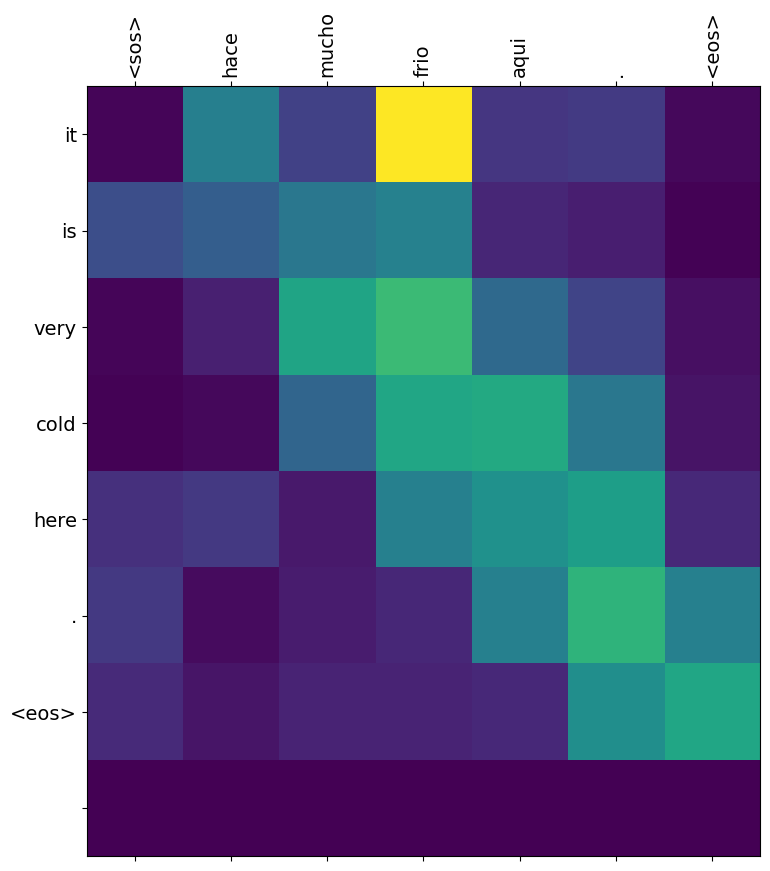

In [42]:
translate(u'hace mucho frío aquí.')

Input: <sos> trata de averiguarlo . <eos>
Predicted Translation: try to find out . <eos> 


<ipython-input-38-195a7c32b7e5>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
<ipython-input-38-195a7c32b7e5>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


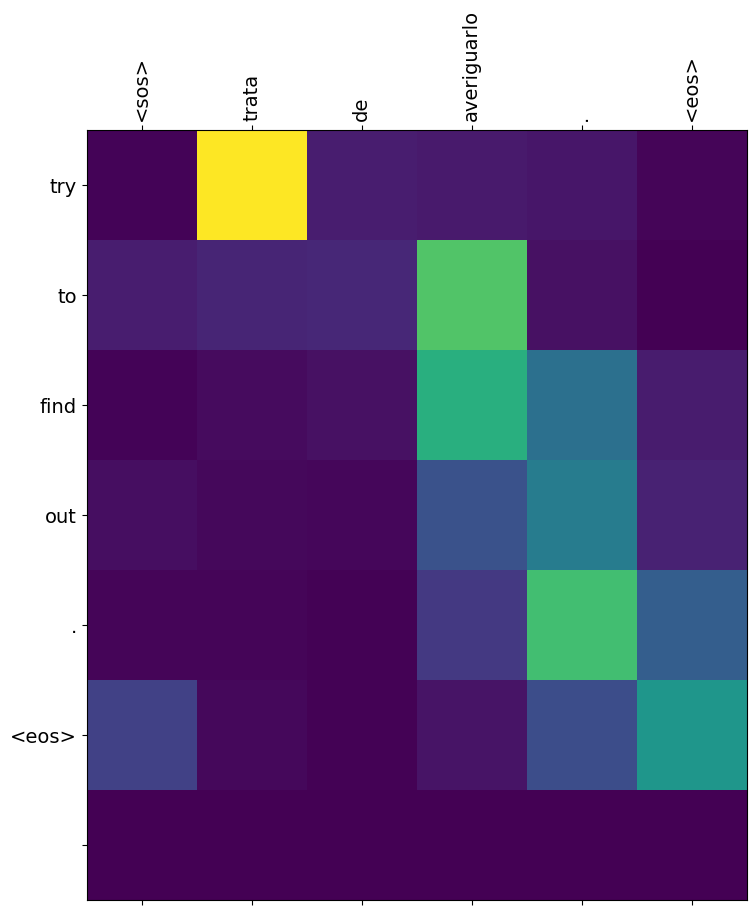

In [43]:
translate(u'trata de averiguarlo.')

Input: <sos> todavia estan en casa ? <eos>
Predicted Translation: are you still at home now ? <eos> 


<ipython-input-38-195a7c32b7e5>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
<ipython-input-38-195a7c32b7e5>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


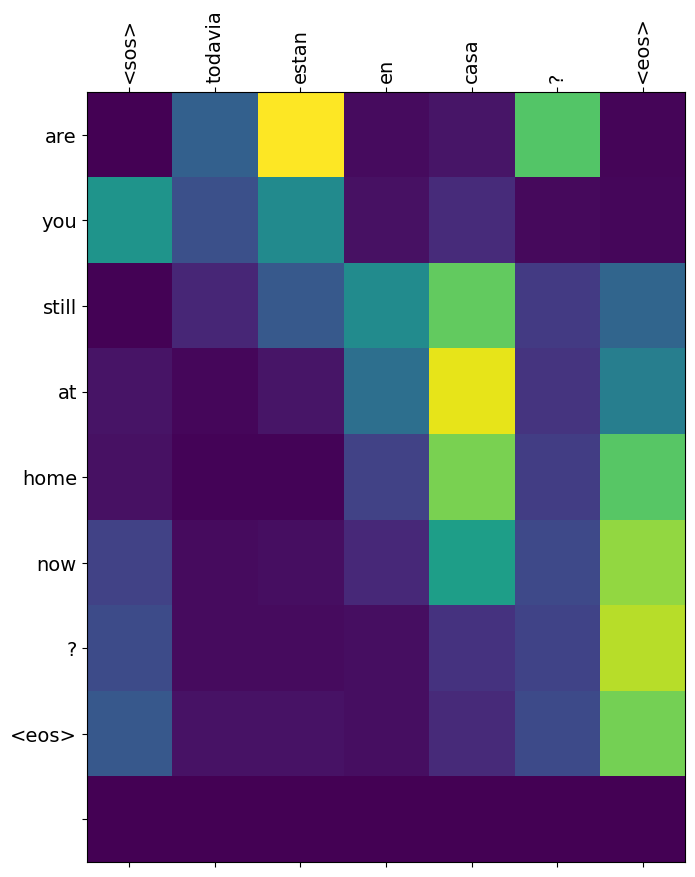

In [44]:
translate(u'¿todavía están en casa?')